# Rating Prediction using review text

We use the user reviews for prediction of the rating.

In [1]:
import pandas as pd
import json
from tqdm import tqdm
line_count = len(open("yelp_dataset/review.json").readlines())
user_ids, business_ids, stars, dates,reviews = [], [], [], [],[]
with open("yelp_dataset/review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]] 
        stars += [blob["stars"]]
        dates += [blob["date"]]
        reviews +=[blob["text"]]
ratings=pd.DataFrame({"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates,"reviews":reviews})
user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [00:48<00:00, 136533.89it/s]


First we will divide the whole dataset into two parts, one is the latest rating for active users, the other is the remaining data.

In [2]:
sorted_ratings=ratings.set_index(['user_id','date']).sort_index(ascending=False)
latest_ratings=sorted_ratings.groupby('user_id').head(1).reset_index()
latest_ratings=latest_ratings[latest_ratings['user_id'].isin(active_users)]

In [115]:
remaining_ratings=pd.concat([ratings, latest_ratings]).drop_duplicates(keep=False)

/Users/jasmine1231/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [22]:
new_ratings=pd.concat([latest_ratings, remaining_ratings])

/Users/jasmine1231/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


We will use all the review data from the original dataset to turn all of our reviews into vectors. <br>
<br>
Sometimes, the reviews will contain phrases like "not good", so we cannot only consider words independently. <br>
When we break a text into n-grams, we consider several words grouped together to be a single word. “The food was not great” would be represented using bi-grams as (the food, food was, was not, not great), and this would allow our system to learn that not great is a typically negative statement because it appears in many negative reviews. <br>
We will use unigrams (single words) and bigrams (two words at a time) since longer combinations of words will lead to great memory cost.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(ngram_range=(1,2))
t1 = datetime.now()

# the 'fit' builds up the vocabulary from all the reviews
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = vectorizer.fit_transform(new_ratings.reviews)
print(datetime.now() - t1)

0:54:19.473436


In [24]:
X_train=vectors[286130:,:]
y_train=remaining_ratings.rating
X_test=vectors[:286130,:]
y_test=latest_ratings.rating
print(X_train.shape)
print(len(y_train))
print(X_test.shape)
print(len(y_test))

(6399764, 26536440)
6399764
(286130, 26536440)
286130


In [25]:
from sklearn.svm import LinearSVC

# initialise the SVM classifier
classifier = LinearSVC()

# train the classifier
t1 = datetime.now()
classifier.fit(X_train, y_train)
print(datetime.now() - t1)

2:06:36.175164


In [26]:
preds = classifier.predict(X_test)

In [27]:
testing_result_df=pd.DataFrame({'prediction':preds,'actual':y_test})
testing_result_df['difference'] = testing_result_df['prediction'] - testing_result_df['actual'] 
testing_result_df.loc[abs(testing_result_df['difference']) == 4]

,prediction,actual,difference
261,1.0,5.0,-4.0
897,1.0,5.0,-4.0
2367,1.0,5.0,-4.0
3700,5.0,1.0,4.0
5884,5.0,1.0,4.0
...,...,...,...
1629642,5.0,1.0,4.0
1631618,1.0,5.0,-4.0
1633937,1.0,5.0,-4.0
1634972,1.0,5.0,-4.0


In [28]:
def compute_average_word_num(i):
    a=ratings.loc[testing_result_df.loc[abs(testing_result_df['difference']) == i].index.tolist()].reviews
    word_sum=0
    for j in a:
        word_sum+=len(j.split())
    avg_word_num=word_sum/len(a)
    return i,avg_word_num,len(a)
x=[]
y=[]
z=[]
for k in range(5):
    x.append(compute_average_word_num(k)[0])
    y.append(compute_average_word_num(k)[1])
    z.append(compute_average_word_num(k)[2])

In [29]:
import numpy as np
np.corrcoef(x,y)

array([[ 1.        , -0.40866349],
       [-0.40866349,  1.        ]])

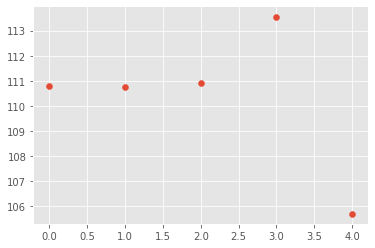

[0, 1, 2, 3, 4]
[110.78894838416711, 110.7600531374541, 110.92331566015777, 113.56104651162791, 105.69548286604362]


In [30]:
# Correction Matrix Plot
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
plt.scatter(x, y)
plt.show()
print(x)
print(y)

In the above graph, x axis represents the absolute difference between predicted rating and actual rating, y axis represents the average review length. We can see that when the length of the review is relatively short, it is mostly likely that the prediction will get completely wrong. Maybe this happens because there is relatively less information in the short reviews and is difficult to decide the sentiment in it.

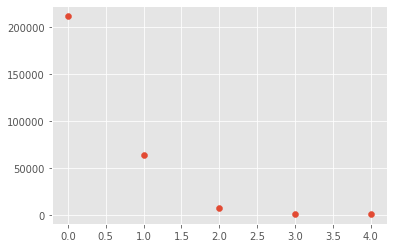

In [31]:
# Correction Matrix Plot
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
plt.scatter(x, z)
plt.show()

In the above graph, x axis represents the absolute difference between predicted rating and actual rating, y axis represents the number of data. We can clearly see a long tail.

In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, preds))

0.7388529689302066


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         1.0       0.77      0.88      0.82     46475
         2.0       0.49      0.35      0.41     22398
         3.0       0.51      0.42      0.46     24851
         4.0       0.52      0.49      0.51     48518
         5.0       0.85      0.89      0.87    143888

    accuracy                           0.74    286130
   macro avg       0.63      0.61      0.61    286130
weighted avg       0.72      0.74      0.73    286130



From this result, we can see the model is biased to different ratings. Particularly for ratings 2,3,4 , their accuracy is much lower than 1 and 5. Maybe we should train the model on balanced dataset.

In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, preds))

[[ 40717   3576   1020    405    757]
 [  8557   7826   4230   1104    681]
 [  2312   3845  10508   6275   1911]
 [   495    584   4198  23710  19531]
 [   527    139    802  13773 128647]]


### balanced testing 
We have more examples of texts that typically have a 5-star rating than texts that typically have a 2-star rating. Because of the probabilistic models at the base of most machine learning classifiers, we’ll get less biased predictions if we train the system on balanced data. This means that ideally we should have the same number of examples of each review type.

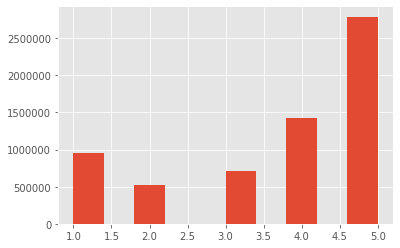

In [93]:
remaining_ratings['rating'].hist()

In [116]:
from collections import Counter

def balance_classes(xs, ys):
    freqs = Counter(ys)

    # the least common class is the maximum number we want for all classes
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for x, y in zip(remaining_ratings.reviews,remaining_ratings.rating):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(x)
        num_added[y] += 1
    return new_xs, new_ys


In [118]:
t1 = datetime.now()
balanced_x, balanced_y = balance_classes(remaining_ratings.reviews, remaining_ratings.rating)

latest_ratings_list=latest_ratings.reviews.tolist()
new_ratings_reviews=latest_ratings_list+balanced_x


vectorizer1 = TfidfVectorizer(ngram_range=(1,2))

vectors1 = vectorizer1.fit_transform(new_ratings_reviews)
X_train1=vectors1[286130:,:]
X_test1=vectors1[:286130,:]
y_test1=latest_ratings.rating

print(datetime.now() - t1)

0:26:54.649315


In [127]:
# initialise the SVM classifier
classifier1 = LinearSVC()

# train the classifier
t1 = datetime.now()
classifier1.fit(X_train1, balanced_y)

print(datetime.now() - t1)

0:14:47.429006


In [128]:
preds2=classifier1.predict(X_test1)
print(accuracy_score(y_test, preds2))
print(classification_report(y_test1, preds2))

0.6918288889665537
              precision    recall  f1-score   support

         1.0       0.80      0.80      0.80     46475
         2.0       0.41      0.54      0.47     22398
         3.0       0.41      0.48      0.44     24851
         4.0       0.45      0.52      0.48     48518
         5.0       0.89      0.78      0.83    143888

    accuracy                           0.69    286130
   macro avg       0.59      0.62      0.60    286130
weighted avg       0.72      0.69      0.70    286130



A balanced train test does not have higher accuracy than the previous train test. This may due to the decrease in the size of text data.

In [129]:
testing_result_df1=pd.DataFrame({'prediction':preds2,'actual':y_test})
testing_result_df1['difference'] = testing_result_df1['prediction'] - testing_result_df1['actual'] 

In [134]:
def compute_average_word_num1(i):
    a=ratings.loc[testing_result_df1.loc[abs(testing_result_df1['difference']) == i].index.tolist()].reviews
    word_sum=0
    for j in a:
        word_sum+=len(j.split())
    avg_word_num=word_sum/len(a)
    return i,avg_word_num,len(a)
x=[]
y=[]
z=[]
for k in range(5):
    x.append(compute_average_word_num1(k)[0])
    y.append(compute_average_word_num1(k)[1])
    z.append(compute_average_word_num1(k)[2])

In [135]:
for k in range(5):
    print(compute_average_word_num1(k))

(0, 110.6703055775866, 197953)
(1, 111.01783129359126, 75990)
(2, 112.08730691739423, 8934)
(3, 110.01880877742947, 1914)
(4, 105.84914115011202, 1339)


In [136]:
import numpy as np
np.corrcoef(x,y)

array([[ 1.        , -0.70095882],
       [-0.70095882,  1.        ]])

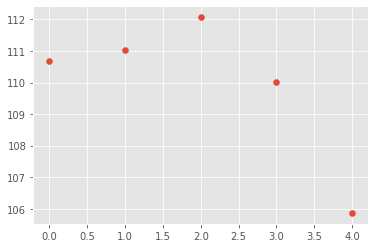

[0, 1, 2, 3, 4]
[110.6703055775866, 111.01783129359126, 112.08730691739423, 110.01880877742947, 105.84914115011202]


In [137]:
# Correction Matrix Plot
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
plt.scatter(x, y)
plt.show()
print(x)
print(y)

Combine the graph with the graph we produced for the last test, we can clearly see that when a review is short, it is likely to predict completely wrong since short reviews may contain core information and there is less information in it. Sometimes less information may lead to incorrect prediction.

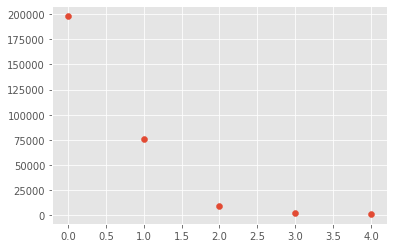

In [138]:
# Correction Matrix Plot
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
plt.scatter(x, z)
plt.show()

In the above graph, x axis represents the absolute difference between predicted rating and actual rating, y axis represents the number of data. We can clearly see a long tail.

### all the texts but balanced svd

In [ ]:
from collections import Counter

def balance_classes(xs, ys):
    freqs = Counter(ys)

    # the least common class is the maximum number we want for all classes
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for x, y in zip(remaining_ratings.reviews,remaining_ratings.rating):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(x)
        num_added[y] += 1
    return new_xs, new_ys

In [ ]:
t1 = datetime.now()
balanced_x, balanced_y = balance_classes(remaining_ratings.reviews, remaining_ratings.rating)

latest_ratings_list=latest_ratings.reviews.tolist()
new_ratings_reviews=latest_ratings_list+balanced_x

vectors2 = vectorizer.transform(balanced_x)

print(datetime.now() - t1)

In [ ]:
from sklearn.svm import LinearSVC
# initialise the SVM classifier
classifier2 = LinearSVC()

# train the classifier
t1 = datetime.now()
classifier2.fit(vectors2, balanced_y)

print(datetime.now() - t1)

In [ ]:
from sklearn.metrics import accuracy_score
preds2=classifier2.predict(X_test)
print(accuracy_score(y_test, preds2))
from sklearn.metrics import classification_report
print(classification_report(y_test, preds2))

This is almost the same accuracy as the partial text data which indicates balanced text will not lead to a more accurate prediction.

### Active users only

In all the above step, we used all the reviews from the dataset and that may be not accurate since we did not separate active users from inactive users. Next step we will use data from active users only and predict their rating. 

In [3]:
active_ratings=ratings[ratings['user_id'].isin(active_users)]
remaining_active_ratings=pd.concat([active_ratings, latest_ratings]).drop_duplicates(keep=False)
new_active_ratings=pd.concat([latest_ratings, remaining_active_ratings])

/Users/jasmine1231/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/Users/jasmine1231/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer_active = TfidfVectorizer(ngram_range=(1,2))
t1 = datetime.now()

# the 'fit' builds up the vocabulary from all the reviews
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors_active = vectorizer_active.fit_transform(new_active_ratings.reviews)
print(datetime.now() - t1)

0:25:37.791186


In [5]:
X_active_train=vectors_active[286130:,:]
y_active_train=remaining_active_ratings.rating
X_active_test=vectors_active[:286130,:]
y_active_test=latest_ratings.rating
print(X_active_train.shape)
print(len(y_active_train))
print(X_active_test.shape)
print(len(y_active_test))

(4252142, 21807313)
4252142
(286130, 21807313)
286130


In [6]:
from sklearn.svm import LinearSVC

# initialise the SVM classifier
classifier_active = LinearSVC()

# train the classifier
t1 = datetime.now()
classifier_active.fit(X_active_train, y_active_train)
print(datetime.now() - t1)

1:20:03.673476


In [10]:
preds_active = classifier_active.predict(X_active_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_active_test, preds_active))
from sklearn.metrics import classification_report
print(classification_report(y_active_test, preds_active))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_active_test, preds_active))

0.7328661797085241
              precision    recall  f1-score   support

         1.0       0.79      0.85      0.82     46475
         2.0       0.48      0.36      0.42     22398
         3.0       0.49      0.44      0.47     24851
         4.0       0.51      0.52      0.51     48518
         5.0       0.86      0.88      0.87    143888

    accuracy                           0.73    286130
   macro avg       0.63      0.61      0.62    286130
weighted avg       0.72      0.73      0.73    286130

[[ 39480   4266   1288    557    884]
 [  7619   8158   4650   1258    713]
 [  1971   3735  10998   6378   1769]
 [   448    540   4494  25079  17957]
 [   467    159    951  16331 125980]]


We can see that the accuracy is almost the same as using the whole dataset so the review of the inactive users do not make much difference to the active users' review.

### Inactive users only

In [11]:
inactive_users = user_counts.loc[user_counts < 5].index.tolist()
latest_ratings=sorted_ratings.groupby('user_id').head(1).reset_index()
latest_inactive_ratings=latest_ratings[latest_ratings['user_id'].isin(inactive_users)]
inactive_ratings=ratings[ratings['user_id'].isin(inactive_users)]
remaining_inactive_ratings=pd.concat([inactive_ratings, latest_inactive_ratings]).drop_duplicates(keep=False)
new_inactive_ratings=pd.concat([latest_inactive_ratings, remaining_inactive_ratings])

/Users/jasmine1231/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
/Users/jasmine1231/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [12]:
# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer_inactive = TfidfVectorizer(ngram_range=(1,2))
t1 = datetime.now()

# the 'fit' builds up the vocabulary from all the reviews
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors_inactive = vectorizer_inactive.fit_transform(new_inactive_ratings.reviews)
print(datetime.now() - t1)

0:09:38.301589


In [15]:
print(len(latest_inactive_ratings))
print(len(remaining_inactive_ratings))

1351008
796615


In [17]:
from sklearn.model_selection import train_test_split
X_inactive_train, X_inactive_test, y_inactive_train, y_inactive_test = train_test_split(vectors_inactive, new_inactive_ratings.rating, test_size=0.33, random_state=42)


In [18]:
# initialise the SVM classifier
classifier_inactive = LinearSVC()

# train the classifier
t1 = datetime.now()
classifier_inactive.fit(X_inactive_train, y_inactive_train)
print(datetime.now() - t1)

0:06:04.402475


In [19]:
preds_inactive = classifier_inactive.predict(X_inactive_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_inactive_test, preds_inactive))
from sklearn.metrics import classification_report
print(classification_report(y_inactive_test, preds_inactive))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_inactive_test, preds_inactive))



0.7801390119596566
              precision    recall  f1-score   support

         1.0       0.81      0.92      0.86    158338
         2.0       0.48      0.31      0.38     51088
         3.0       0.49      0.30      0.37     41637
         4.0       0.53      0.36      0.43     93213
         5.0       0.85      0.95      0.90    364440

    accuracy                           0.78    708716
   macro avg       0.63      0.57      0.59    708716
weighted avg       0.75      0.78      0.76    708716

[[145614   7915   1630    792   2387]
 [ 24675  15903   6180   2434   1896]
 [  6265   7583  12491  10370   4928]
 [  1633   1399   4478  33890  51813]
 [  1729    323    808  16581 344999]]


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y_inactive_test, preds_inactive))
print(rms)

0.6582728006297921


It is surprising that prediction for the reviews of inactive users is much higher than those of the active users. This may due to larger size of dataset that makes it more accurate.